In [14]:
library(ggbiplot)
library(factoextra)
library(cluster)
library(fpc)
library(gplots)
library(pheatmap)
library(edgeR)
library(topGO)
library(repr)
data(geneList)
library(VennDiagram)

<img src="logo.png" alt="venn" style="width: 400px;"/>
<h1><center>V Edición</center></h1>
<h1><center>Los pacientes según la BioInformática</center></h1>
<img src="logobio.jpg" alt="venn" style="width: 700px;"/>

# Who is this guy?
<table>
    <tr>
        <td>
            Adrian García Moreno
        </td>
        <td rowspan="4">
<img src="https://media.licdn.com/dms/image/C5603AQHhvD9AjzkSOA/profile-displayphoto-shrink_100_100/0?e=1557964800&v=beta&t=dflumfkNEv6y9qq5gCJnrzmlbWHPsqS0uHUU0CkM74E" style="height: 100px;"/>
        </td>
        <td rowspan="4">
<img src="http://bioinfo.genyo.es/wp-content/uploads/2019/02/filled_bioinformatics-GENyO-junta-andalucia-pfizer-universidad-granada-logo-retina.png" style="width: 200px;"/>
        </td>
    </tr>
    <tr>
        <td>
    Grado en Biología UGR        
        </td>
    </tr>
    <tr>
        <td>
    Máster en BioInformática (ENS-ISCIII-CNIO-UAM)
        </td>
    </tr>
    <tr>
        <td>
    Técnico Contratado
        </td>
    </tr>
</table>

###### 1 Our patients
###### 2 Their disease(s)
###### 3 Their biology

<img src="https://www.cancer.gov/PublishedContent/Images/about-nci/organization/ccg/research/computational-genomics/gdc/tcga-infographic-enlarge.__v500169753.png" style="heigth: 700px;"/>

# Our Case
### Genomic Classification Of Cutaneous Melanoma, 2015. The Cancer Genome Atlas Consortium
[Cell, Volume 161, Issue 7: 1681-1696 doi:10.1016/j.cell.2015.05.044](https://www.cell.com/cell/fulltext/S0092-8674(15)00634-0?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867415006340%3Fshowall%3Dtrue)


## 0. Load Input 

In [39]:
geneExpressionMatrix_file <- "SKCM_all_normalized.normalized_results.tsv"
geneExpressionMatrix <- read.delim(geneExpressionMatrix_file,stringsAsFactors = F)
geneExpressionMatrix <- geneExpressionMatrix[grep("?",geneExpressionMatrix$gene_id,fixed = T,invert = T),]
rownames(geneExpressionMatrix) <- geneExpressionMatrix$gene_id
geneExpressionMatrix$gene_id <- NULL
colnames(geneExpressionMatrix) <- paste0("P",c(1:ncol(geneExpressionMatrix)))

dim(geneExpressionMatrix)
head(geneExpressionMatrix)

[1] 20502   331

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,⋯,P322,P323,P324,P325,P326,P327,P328,P329,P330,P331
A1BG|1,155.1233,155.4770,163.2854,192.7710,126.1811,208.1906,97.7484,252.0017,167.0763,265.9677,⋯,394.8485,167.7144,160.6074,281.9014,596.3061,11.2680,323.6243,128.1446,187.9862,215.5933
A1CF|29974,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,1.1460,0.9990,0.0000,0.0000,0.0000,0.0000,0.0000,0.3400
A2BP1|54715,0.0000,0.0000,0.3883,0.0000,0.0000,0.0000,0.0000,0.0000,0.3091,0.3580,⋯,0.0000,0.0000,0.2865,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6800
A2LD1|87769,189.1884,108.9354,37.1845,139.8418,75.6767,11.4743,38.2306,102.7448,134.0598,181.8424,⋯,84.3644,57.9958,78.6277,256.4236,63.0959,5.8259,63.0305,78.2095,34.3515,82.2883
A2M|2,21202.6952,53539.8408,32380.9087,8658.4800,112176.9612,6132.1631,116121.0624,69856.4347,150348.2989,75773.4227,⋯,18135.5543,6069.0019,8085.2629,29055.1615,8179.4371,35412.6045,396695.5029,35367.4414,34653.5940,86229.0581
A2ML1|144568,0.0000,0.0000,3.1068,0.0000,0.3133,284.0655,0.0000,0.0000,153.6440,177.1925,⋯,0.0000,0.7964,1.7190,0.0000,917.3263,0.3427,276.4439,1.9950,239.0552,0.0000


## 1. Filtering

In [16]:
geneVariance <- apply(geneExpressionMatrix,1,var)
patientVariance <- apply(geneExpressionMatrix,2,var)

geneMOSTvariants <- which(geneVariance > mean(geneVariance))
patientsMOSTvariants <- which(patientVariance > mean(patientVariance))

filteredMatrix <- geneExpressionMatrix[geneMOSTvariants,patientsMOSTvariants]
rownames(filteredMatrix) <- gsub("\\|.*","",rownames(filteredMatrix))
dim(filteredMatrix)
head(filteredMatrix)

[1] 685  92

,P13,P17,P18,P22,P23,P26,P31,P34,P35,P40,⋯,P299,P302,P303,P311,P314,P317,P318,P322,P326,P328
A2M,1666.3244,2439.608,48609.220,551899.9956,34960.096,144641.617,15526.894,7216.3707,18504.622,25571.707,⋯,60007.009,5375.528,23780.423,26836.331,143640.709,72088.367,73306.221,18135.554,8179.4371,396695.503
ABHD2,708.3693,2587.865,2804.709,71349.4492,2216.610,5035.367,1635.033,588.7850,16996.570,1631.251,⋯,10272.193,1630.391,2583.095,3726.733,58374.172,2825.709,4130.326,2576.127,1607.7397,3017.521
ABR,11143.6583,5734.116,2174.515,6037.9981,2868.978,6682.860,18640.298,7809.1900,2434.340,3187.281,⋯,3133.361,5334.771,7890.043,6239.652,5127.152,4075.023,4339.348,4019.956,6550.5717,8195.652
ACP5,9421.9154,11255.867,4807.017,482.2947,2705.686,2895.841,15672.788,8355.1402,4030.977,7825.284,⋯,4739.160,8364.632,2450.931,9904.842,2525.828,3934.126,11230.576,9661.862,6285.8399,1951.655
ACSL3,3881.7947,4787.922,8281.163,13471.1318,4107.436,6740.381,2468.730,446.2617,4851.422,6657.663,⋯,3085.214,11204.711,4336.318,7382.557,8013.907,4021.043,3407.017,5440.872,770.4485,4861.778
ACTB,226489.2148,156484.545,147651.893,82876.3214,199311.819,86546.444,253075.182,265862.9283,145550.614,215821.181,⋯,107876.351,138842.070,79826.648,117122.836,54650.993,86252.973,189482.206,180400.961,198745.8223,131874.432


**Hemos pasado de *20502 genes a 685 y de 331 pacientes a 92*. El filtrado que hemos aplicado consiste en quedarnos con los genes y pacientes con información más heterogenea. Esta no es la mejor práctica, ya que podríamos estar perdiendo patrones sutiles o conservados en la enfermedad que estudiamos. Lo que estamos haciendo seria quedarnos con los elementos más diferenciadores, perdiendo una imagen más holistica e informativa de la enfermeddad.** Pero por el bien de la diamica del taller avanzaremos con esta selección.

## 1.1. HeatMap Preview

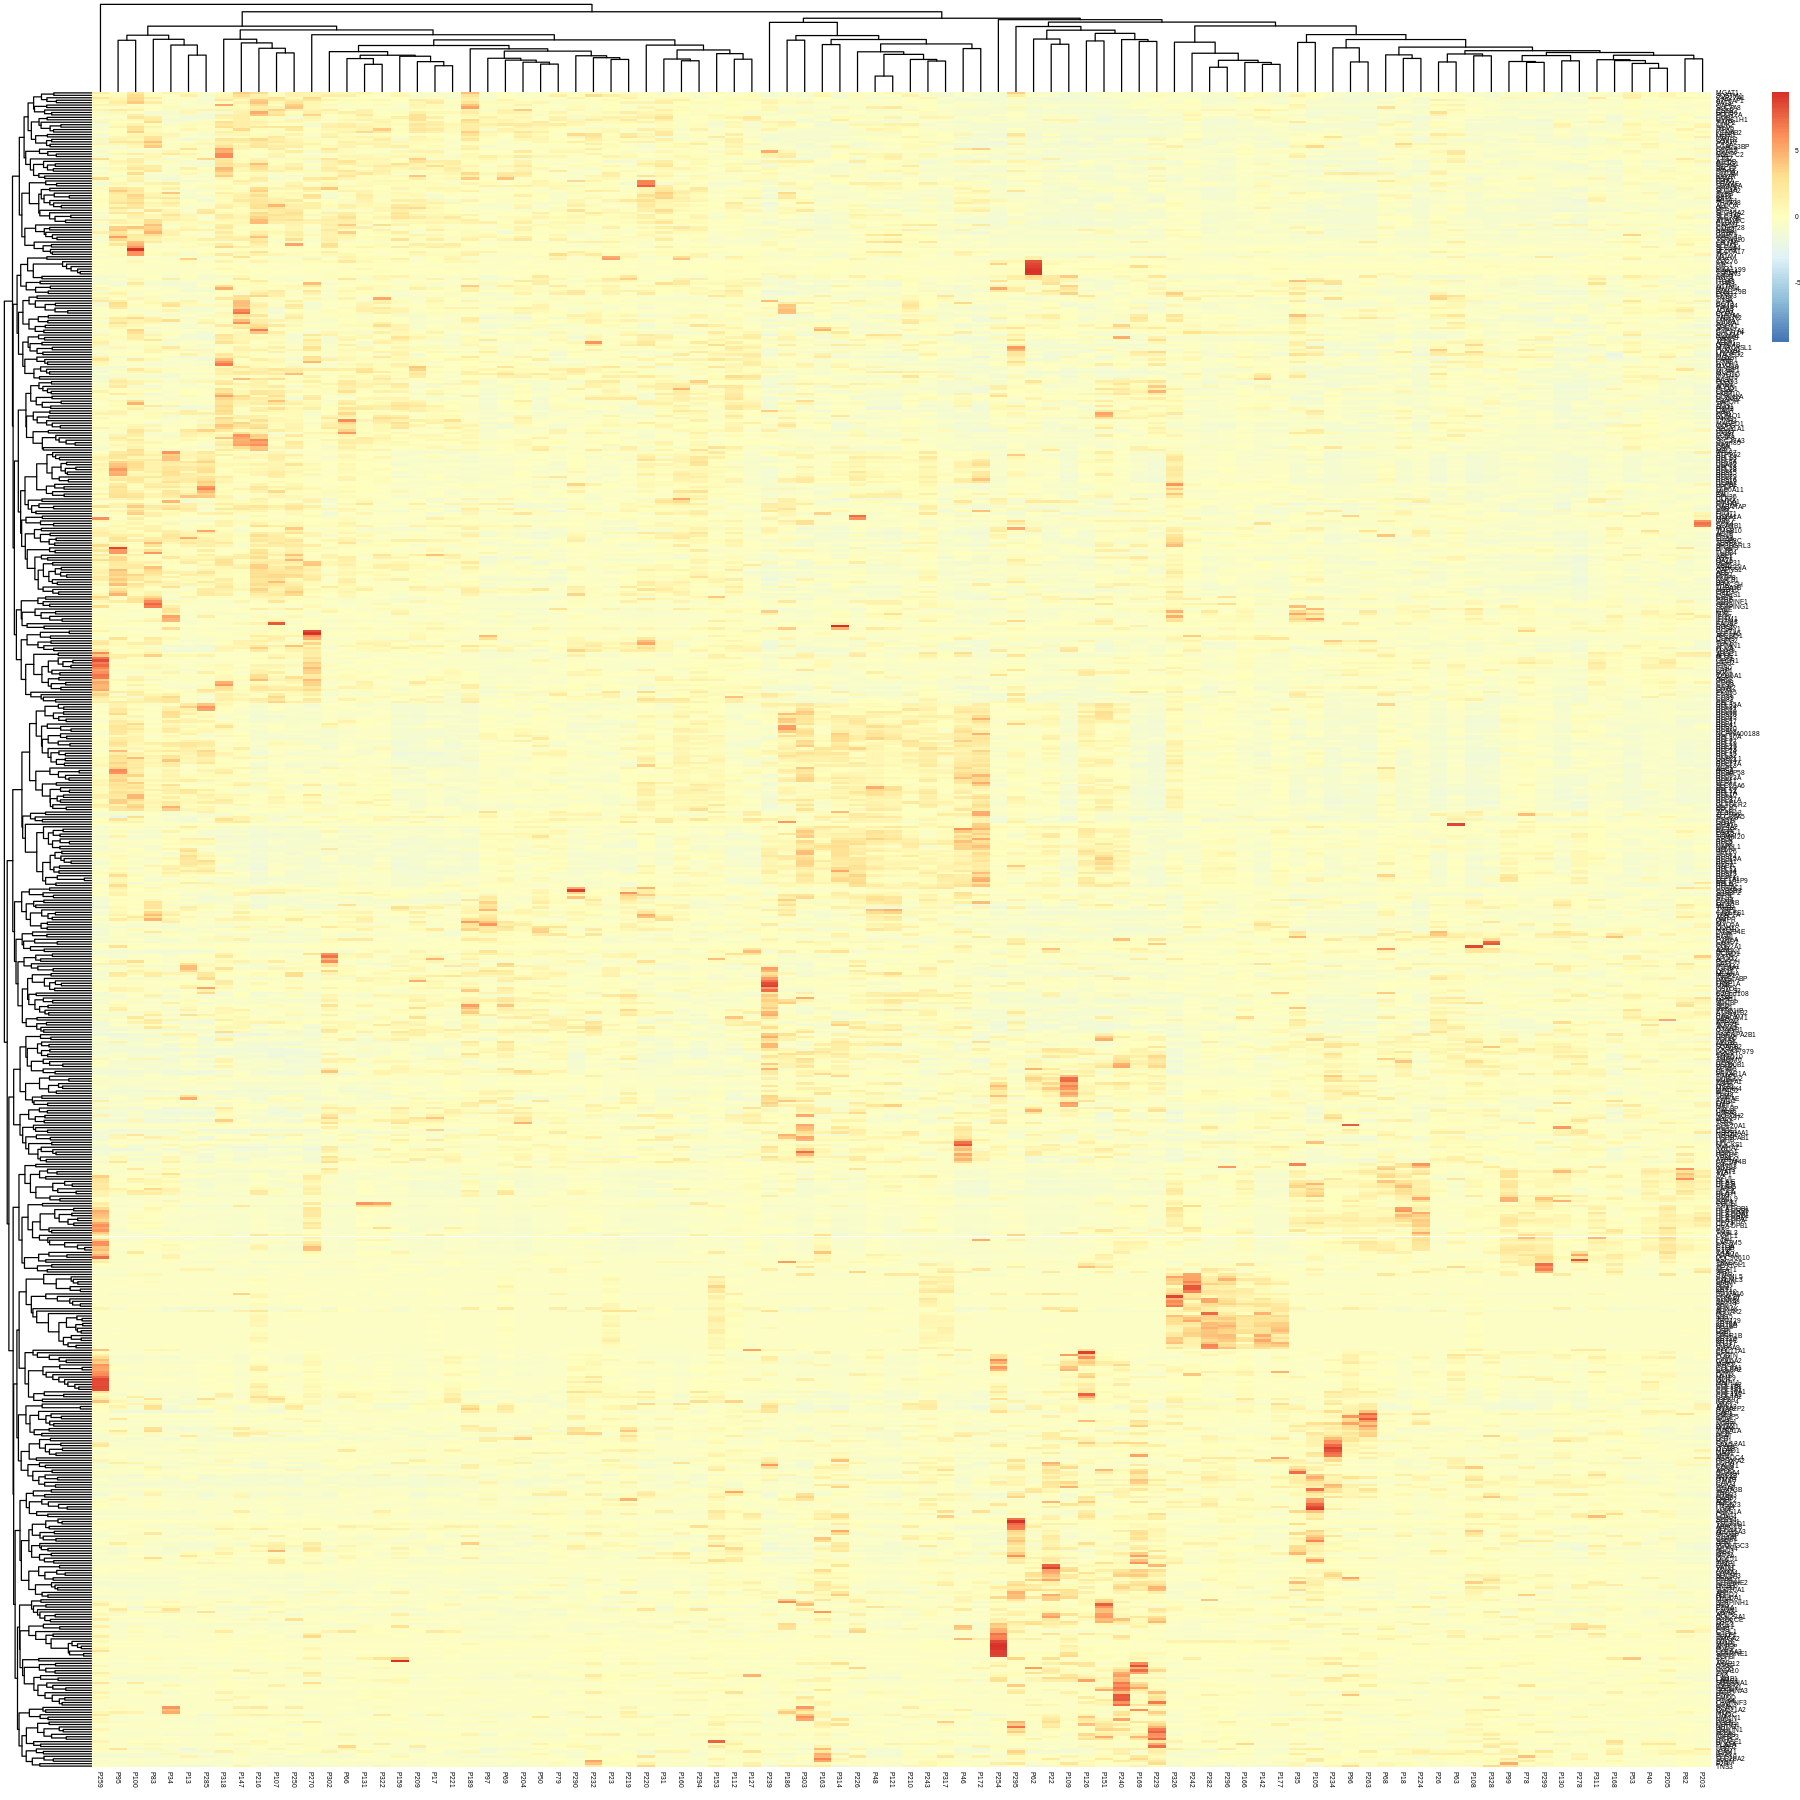

In [17]:
options(repr.plot.width=15, repr.plot.height=15)
pheatmap(filteredMatrix,scale = "row",fontsize=4)

**Este heatmap es excesivamente grande, y aunque se aprecian "manchurrones", excasas, por no decir nulas, conclusiones se pueden sacar de ello. Para facilitar nuestra tarea exploratoria, vamos a fragmentar de algun modo la información que tenemos.**
<center><h1>"Divide y venceras"

# 2. Clustering (K-means)
## 2.1 Genes
### 2.1.2. How many type of gene groups should we expect?

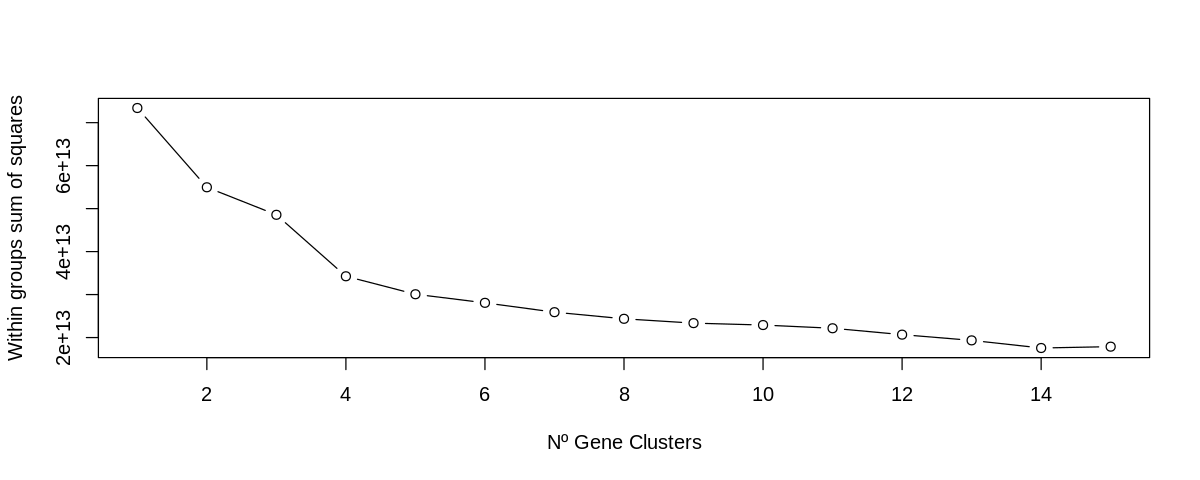

In [18]:
wss <- (nrow(filteredMatrix)-1)*sum(apply(filteredMatrix,2,var))
for (i in 2:15) {
  wss[i] <- sum(kmeans(filteredMatrix,centers=i)$withinss)
}
options(repr.plot.width=10, repr.plot.height=4)
plot(1:15, wss, type="b", xlab="Nº Gene Clusters",ylab="Within groups sum of squares")

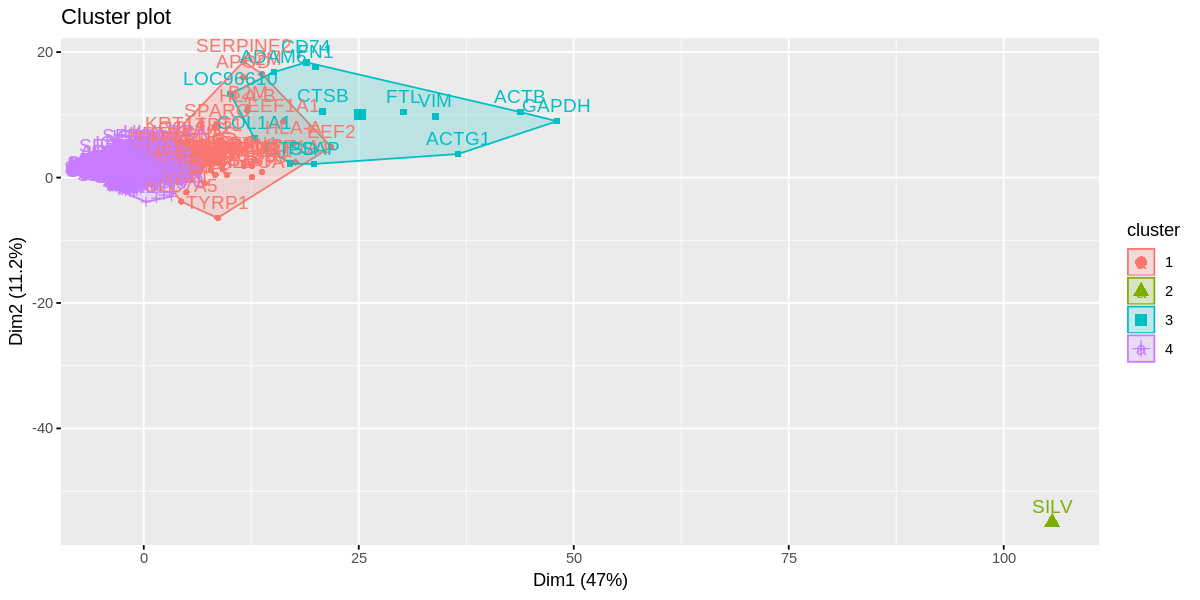

In [40]:
km_fit_genes <- kmeans(filteredMatrix, 4)
options(repr.plot.width=10, repr.plot.height=5)
fviz_cluster(km_fit_genes, data = filteredMatrix)

# Makes sense?
Los grupos de genes que aqui obtengamos caerian bajo una misma ruta o rutas metabólicas muy relacionadas. Conocer estos grupos, a priori, no tiene mayor interes ya que desconocemos cuales son los causantes para la enfermedad que estudiamos.

## 2.2. Patients
### 2.2.1. How many type of patients should we expect?

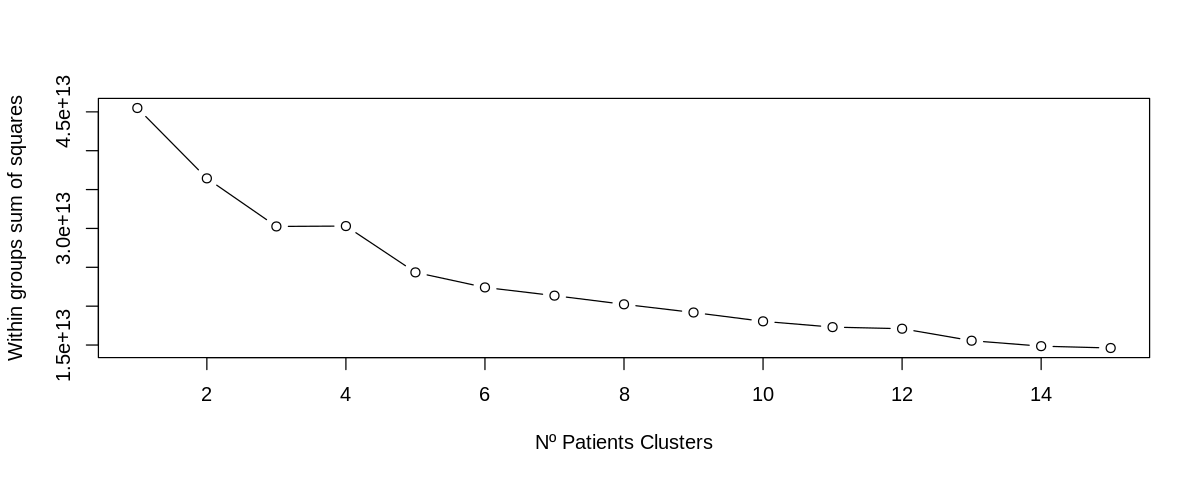

In [41]:
patientsASrows <- t(filteredMatrix)
wss <- (nrow(patientsASrows)-1)*sum(apply(patientsASrows,2,var))
for (i in 2:15) {
  wss[i] <- sum(kmeans(patientsASrows,centers=i)$withinss)
}
options(repr.plot.width=10, repr.plot.height=4)
plot(1:15, wss, type="b", xlab="Nº Patients Clusters",ylab="Within groups sum of squares")

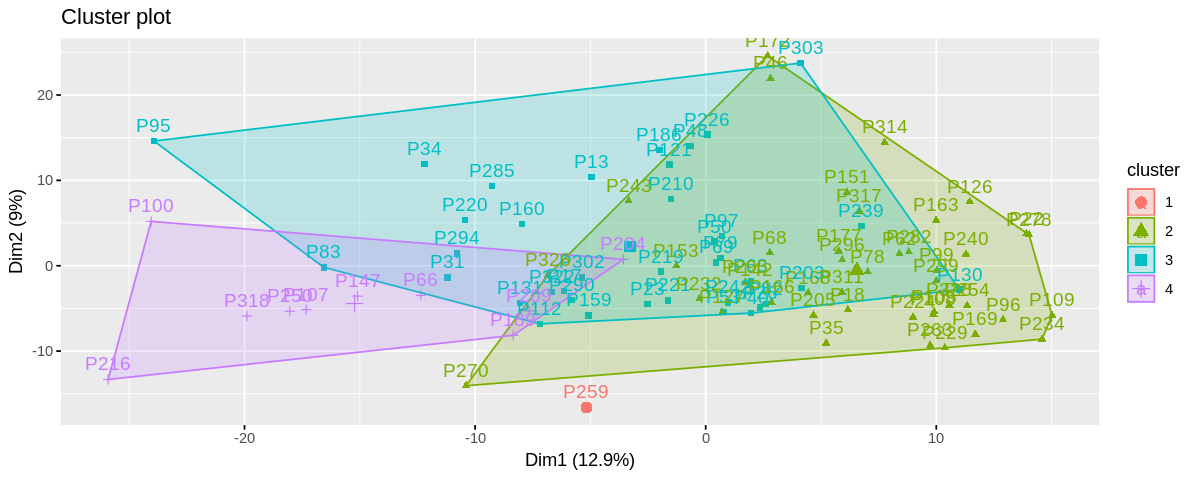

In [42]:
km_fit_patients <- kmeans(patientsASrows, 4) # Centroides
fviz_cluster(km_fit_patients, data = patientsASrows)

<center><h3>Outlayer!!!

In [43]:
outlayer <- table(km_fit_patients$cluster) == 1
outlayer <- names(outlayer)[outlayer] 
outlayer <- which(km_fit_patients$cluster == outlayer)
patientsASrows <- patientsASrows[-outlayer,]

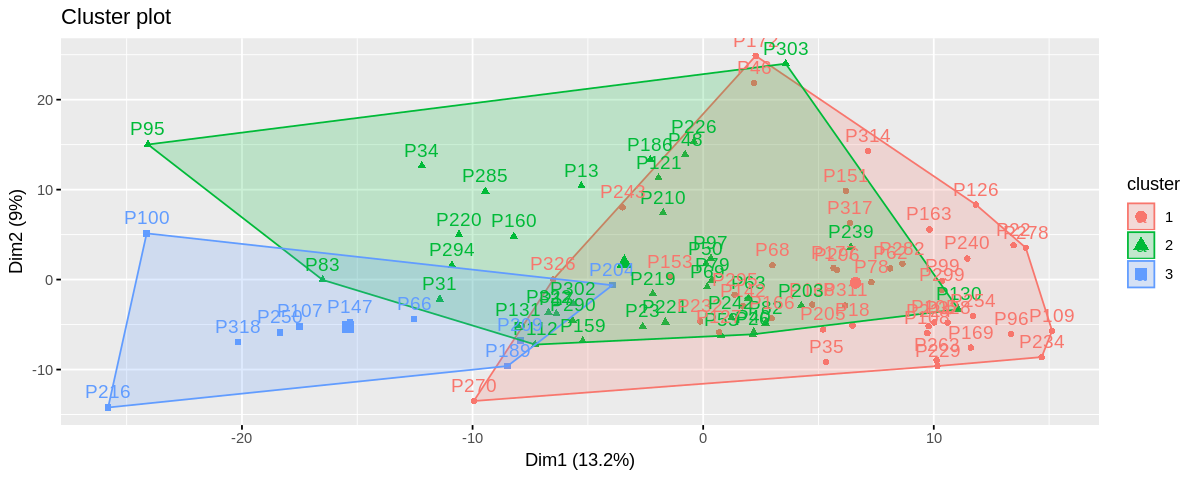

In [45]:
km_fit_patients <- kmeans(patientsASrows, 3) # Centroides
fviz_cluster(km_fit_patients, data = patientsASrows)

Kmeans es uno de los algoritmos de clustering más rudimentarios y sencillos de aplicar. Existen mejores, pero no es objeto de este taller. Nuestros clusters de pacientes se solapan mucho. Por ello tendríamos que pensar en usar otras técnicas como **Kmedioids**, **Non-negative matrix factorization**, **WGCNA**, etc... O más importantemente, combinar varias...

Nuestro siguiente paso es saber que es lo característico de cada grupo. Para ello realizamos un análisis de expression diferencial. Este análisis no es más que una especie de T-student donde la hipotesis nula que se lanza de forma masiva, en nuestro caso, es **Este gen no es representativo de este grupo**. Lo habitual es comparar entre individuos sanos y enfermos, de modo que la hipotesis nula sería **Este gen no es causante de la enfermedad**. Sin embargo en nuestro dataset, solo disponemos de individuos afectados.

## 3. Differential Expression among Groups of Patients

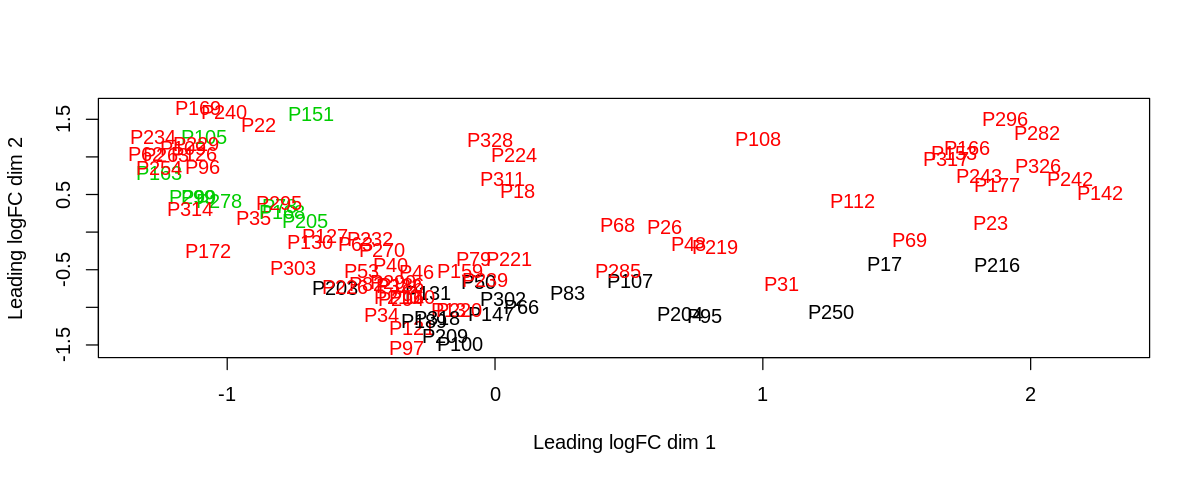

In [24]:
DEobj <- DGEList(t(patientsASrows))
groups <- as.factor(km_fit_patients$cluster)
plotMDS(DEobj, col = as.numeric(groups))

In [46]:
mm <- model.matrix(~0 + groups)
y <- voom(t(patientsASrows), mm)
fit <- lmFit(y, mm)

contr12 <- makeContrasts(groups1 - groups2, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr12)
tmp <- eBayes(tmp)
top.table12 <- topTable(tmp, sort.by = "P", n = Inf)
print("Comparación grupo 1 vs 2")
head(top.table12)

contr13 <- makeContrasts(groups1 - groups3, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr13)
tmp <- eBayes(tmp)
top.table13 <- topTable(tmp, sort.by = "P", n = Inf)
print("Comparación grupo 1 vs 3")
head(top.table13)

contr23 <- makeContrasts(groups2 - groups3, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr23)
tmp <- eBayes(tmp)
top.table23 <- topTable(tmp, sort.by = "P", n = Inf)
print("Comparación grupo 2 vs 3")
head(top.table23)

[1] "Comparación grupo 1 vs 2"


,logFC,AveExpr,t,P.Value,adj.P.Val,B
EPHX1,2.543171,8.258419,8.821945,6.116437e-14,4.189760e-11,21.338006
TSPAN10,3.518368,6.702400,8.561007,2.178163e-13,7.460208e-11,20.068432
SLC27A3,3.046849,6.926613,7.757934,1.054783e-11,2.408421e-09,16.324220
SCARB1,2.218182,8.960961,7.429896,5.048918e-11,8.646273e-09,14.756866
KCNAB2,2.339463,7.935914,7.270082,1.076837e-10,1.475266e-08,14.067089
C1orf85,1.482820,9.152681,6.379800,6.724520e-09,7.677160e-07,9.954335


[1] "Comparación grupo 1 vs 3"


,logFC,AveExpr,t,P.Value,adj.P.Val,B
IGJ,-8.534148,4.649735,-8.284738,8.323800e-13,5.701803e-10,18.24356
GBP4,-5.655244,5.760579,-6.951246,4.819555e-10,1.650698e-07,12.46820
CFH,-3.752549,5.796793,-6.772886,1.105474e-09,2.524166e-07,11.69613
LOC96610,-6.674311,9.717993,-6.647807,1.971034e-09,3.259936e-07,11.16208
VAT1,2.327874,11.182634,6.606910,2.379516e-09,3.259936e-07,10.82855
SLC26A2,-3.844116,7.031254,-6.560791,2.941256e-09,3.357934e-07,10.90861


[1] "Comparación grupo 2 vs 3"


,logFC,AveExpr,t,P.Value,adj.P.Val,B
IGJ,-6.308903,4.649735,-12.855945,2.207349e-22,1.512034e-19,39.89909
LOC96610,-5.594049,9.717993,-8.098426,2.049386e-12,7.019148e-10,17.84260
SFRP1,-4.937233,6.639685,-7.650486,1.764269e-11,4.028413e-09,15.81290
CXCL9,-3.718273,5.817527,-7.435646,4.912838e-11,8.413236e-09,14.84445
GBP4,-3.036684,5.760579,-6.970424,4.406371e-10,6.036728e-08,12.73038
LYZ,-2.633661,7.536984,-6.859350,7.397935e-10,8.445976e-08,12.14995


De estos resultados hay varias medidas que nos interesan mucho. La primera y más importante son nuestros **pValues**. La estadistica bien nos enseña en toda rama de ciencias, que el Pvalue tiene que ser menor de 0.05 para rechazar la hipotesis nula, y en nuestro caso, asumir que dicho gen es significativo. Nos debemos fijar el pValue ajustado (**adj.P.val**), que es más conservativo y se aplica cuando hay muchos pValues calculados (multitesting-correction). Siempre que este pValue sea menor que el umbral determinado, en lo siguiente que nos debemos fijar es el **Fold-Change** (**logFC**). Este estadistico nos indica la direccion de la significancia, es decir, cuanto más o cuanto menos, se diferencia (el gen) entre las dos condiciones que comparamos. Así pues, en una comparativa 1 vs 2, un valor + indica que está mas representado en 1 y el valor - en 2.

In [47]:
threshold <- 0.05 # basic threshold

top12 <- row.names(top.table12)[top.table12$adj.P.Val < threshold]
top13 <- row.names(top.table13)[top.table13$adj.P.Val < threshold]
top23 <- row.names(top.table23)[top.table23$adj.P.Val < threshold]

toVenn1 <- list(top12=top12,top13=top13,top23=top23)
commontopDiffGenes1 <- unique(c(top12,top13,top23))

threshold <- 0.0001  # severe threshold

top12 <- row.names(top.table12)[top.table12$adj.P.Val < threshold]
top13 <- row.names(top.table13)[top.table13$adj.P.Val < threshold]
top23 <- row.names(top.table23)[top.table23$adj.P.Val < threshold]

toVenn2 <- list(top12=top12,top13=top13,top23=top23)
commontopDiffGenes2 <- unique(c(top12,top13,top23))

Nosotros hemos atrapdo varias listas de genes, aplicando  por un lado un cutoff básico **toVenn1 y commontopDiffGenes1 (P.value < 0.05)**, y por otro aplicando, **toVenn2 y commontopDiffGenes2 (P.value < 0.001)**. Que usaremos a continuación para ver como se distribuyen en nuestros grupos.

In [48]:
print("Lists of top differentially expressed genes")
print("CutOff pVal 0.05")
print("By study")
toVenn1
cat("In common",length(commontopDiffGenes1),"\n")
commontopDiffGenes1
print("CutOff pVal 0.0001")
print("By study")
toVenn2
cat("In common",length(commontopDiffGenes2),"\n")
commontopDiffGenes2

[1] "Lists of top differentially expressed genes"
[1] "CutOff pVal 0.05"
[1] "By study"


$top12
  [1] "EPHX1"     "TSPAN10"   "SLC27A3"   "SCARB1"    "KCNAB2"    "C1orf85"  
  [7] "GBA"       "GPR143"    "SLC45A2"   "ITPKB"     "IGSF8"     "TUBB4"    
 [13] "MED15"     "ATP6V0C"   "BACE2"     "CDK2"      "GMPR"      "DPP7"     
 [19] "TTYH3"     "CSTB"      "ATP6AP1"   "EIF4G2"    "STXBP1"    "ARHGDIA"  
 [25] "VAT1"      "CAPG"      "RPS6"      "HNRNPA2B1" "RPL5"      "CSDE1"    
 [31] "CLCN7"     "GSTP1"     "SEPT9"     "SLC1A4"    "MBP"       "LAMB2"    
 [37] "PAEP"      "GPI"       "F2R"       "QPCT"      "TPT1"      "C19orf28" 
 [43] "ALDOA"     "HSP90AA1"  "RPL11"     "EMP3"      "COPG"      "SLC5A3"   
 [49] "L1CAM"     "SIRPA"     "LOC647979" "TUBB2C"    "PLS3"      "TKT"      
 [55] "CLIC4"     "NUCKS1"    "HMCN1"     "ITGA6"     "CAV1"      "YWHAZ"    
 [61] "CYP27A1"   "PRNP"      "ITM2B"     "EEF1A1"    "MLPH"      "RPL26"    
 [67] "HSP90B1"   "AES"       "SILV"      "NAP1L1"    "ECM1"      "SLC7A5"   
 [73] "MCL1"      "EIF3E"     "GSTO1"     "HMGA2"     "MAP4K4"    "SLC3A2"   
 [79] "H3F3B"     "MYO1D"     "ITGB1"     "IQGAP1"    "PTPRZ1"    "ANXA1"    
 [85] "DST"       "CDK4"      "PABPC1"    "CAPN3"     "APLP2"     "SERPINE2" 
 [91] "LAMA4"     "CANX"      "RRBP1"     "RPS8"      "SEMA6A"    "TOMM20"   
 [97] "RPS23"     "EEF1A1P9"  "PTMA"      "CD44"      "PRSS23"    "MFI2"     
[103] "VCAN"      "RPS7"      "RPS24"     "CFH"       "GBP1"      "RPS15A"   
[109] "POLR2A"    "LOXL3"     "RPL6"      "CTGF"      "A2M"       "TMED10"   
[115] "CTSD"      "YWHAE"     "SCARB2"    "GRINA"     "EIF4G1"    "ST13"     
[121] "TSC22D1"   "TPM4"      "GPX1"      "EIF4A2"    "BCAP31"    "HSPD1"    
[127] "GBP4"      "NBL1"      "MLANA"     "TIMP2"     "SCD"       "DUSP6"    
[133] "RPL30"     "POSTN"     "LGALS1"    "LAMB1"     "ASPH"      "SLC26A2"  
[139] "UBA1"      "CAND1"     "LAMP2"     "CD63"      "RPL34"     "CABLES1"  
[145] "CALM1"     "CAP1"      "LZTS1"     "SULF1"     "GRN"       "AHNAK"    
[151] "RPL31"     "CNP"       "PPDPF"     "SLC6A17"   "IGSF3"     "SLC4A2"   
[157] "LGALS3BP"  "NACA"      "MGAT1"     "FKBP8"     "AKAP12"    "BSG"      
[163] "TUBA1B"    "B2M"       "THBS1"     "SPRY4"     "RGS5"      "RPS25"    
[169] "C1QTNF3"   "KIT"       "EIF4B"     "PEG10"     "CALU"      "AP1S2"    
[175] "CAPNS1"    "ACP5"      "SPARC"     "PDIA6"     "C1S"       "CD276"    
[181] "RPL4"      "NPM1"      "SLC7A8"    "SFRP1"     "CYB5R3"    "ATP5B"    
[187] "PTN"       "ALDH1A3"   "TGFBI"     "SYNM"      "PRKCSH"    "CD59"     
[193] "CD81"      "NOTCH2"    "BAT2"      "STAT1"     "TFAP2A"    "COL12A1"  
[199] "TRIM28"    "PSMB4"     "RPN2"      "ACTG1"     "RPS12"     "NME2"     
[205] "UBA52"     "TIMP3"     "ISLR"      "TPI1"      "TMSL3"     "HAPLN1"   
[211] "RPS20"     "NCL"       "LYZ"       "CTSA"      "RPS13"     "PLA1A"    
[217] "SQSTM1"    "SPARCL1"   "PSAP"      "ABR"       "PLAU"      "CTSZ"     
[223] "SPTBN1"    "LYST"      "MMP11"     "NGFR"      "PRKDC"     "APOC2"    
[229] "DCN"       "PHLDA1"    "SLC20A1"   "FSCN1"     "GAPDH"     "PRKAR1A"  
[235] "TXNIP"     "GJB2"      "C4A"       "CHPF"      "APP"       "ATP5G2"   
[241] "LAPTM5"    "IGFBP5"    "HLA-DRA"   "RPL15"     "COL1A2"    "DCBLD2"   
[247] "LAMC1"     "UBB"       "IFI16"     "LAMP1"    

$top13
  [1] "IGJ"       "GBP4"      "CFH"       "LOC96610"  "VAT1"      "SLC26A2"  
  [7] "LYZ"       "SYNM"      "C4A"       "SPRY4"     "CXCL9"     "CLIC4"    
 [13] "GBP1"      "SFRP1"     "DUSP6"     "ARHGDIA"   "ITM2B"     "TIMP2"    
 [19] "LCP1"      "MCL1"      "MED15"     "B2M"       "MGP"       "SPARCL1"  
 [25] "LAPTM5"    "STAT1"     "TPT1"      "IFI16"     "LOXL3"     "C1QA"     
 [31] "ADAM6"     "ANXA1"     "BACE2"     "SLC5A3"    "PTPRZ1"    "HNRNPA2B1"
 [37] "CECR1"     "IFITM1"    "ITGB2"     "LOC647979" "EIF4A2"    "C1QTNF3"  
 [43] "C1QB"      "C1QC"      "NAP1L1"    "C1S"       "TMSL3"     "ITGA10"   
 [49] "ACTG1"     "HMCN1"     "GSTP1"     "IQGAP1"    "ITGA6"     "F2R"      
 [55] "GPI"       "EIF4G2"    "

In common 339 


[1] "EPHX1"     "TSPAN10"   "SLC27A3"   "SCARB1"    "KCNAB2"    "C1orf85"  
  [7] "GBA"       "GPR143"    "SLC45A2"   "ITPKB"     "IGSF8"     "TUBB4"    
 [13] "MED15"     "ATP6V0C"   "BACE2"     "CDK2"      "GMPR"      "DPP7"     
 [19] "TTYH3"     "CSTB"      "ATP6AP1"   "EIF4G2"    "STXBP1"    "ARHGDIA"  
 [25] "VAT1"      "CAPG"      "RPS6"      "HNRNPA2B1" "RPL5"      "CSDE1"    
 [31] "CLCN7"     "GSTP1"     "SEPT9"     "SLC1A4"    "MBP"       "LAMB2"    
 [37] "PAEP"      "GPI"       "F2R"       "QPCT"      "TPT1"      "C19orf28" 
 [43] "ALDOA"     "HSP90AA1"  "RPL11"     "EMP3"      "COPG"      "SLC5A3"   
 [49] "L1CAM"     "SIRPA"     "LOC647979" "TUBB2C"    "PLS3"      "TKT"      
 [55] "CLIC4"     "NUCKS1"    "HMCN1"     "ITGA6"     "CAV1"      "YWHAZ"    
 [61] "CYP27A1"   "PRNP"      "ITM2B"     "EEF1A1"    "MLPH"      "RPL26"    
 [67] "HSP90B1"   "AES"       "SILV"      "NAP1L1"    "ECM1"      "SLC7A5"   
 [73] "MCL1"      "EIF3E"     "GSTO1"     "HMGA2"     "MAP4K4"    "SLC3A2"   
 [79] "H3F3B"     "MYO1D"     "ITGB1"     "IQGAP1"    "PTPRZ1"    "ANXA1"    
 [85] "DST"       "CDK4"      "PABPC1"    "CAPN3"     "APLP2"     "SERPINE2" 
 [91] "LAMA4"     "CANX"      "RRBP1"     "RPS8"      "SEMA6A"    "TOMM20"   
 [97] "RPS23"     "EEF1A1P9"  "PTMA"      "CD44"      "PRSS23"    "MFI2"     
[103] "VCAN"      "RPS7"      "RPS24"     "CFH"       "GBP1"      "RPS15A"   
[109] "POLR2A"    "LOXL3"     "RPL6"      "CTGF"      "A2M"       "TMED10"   
[115] "CTSD"      "YWHAE"     "SCARB2"    "GRINA"     "EIF4G1"    "ST13"     
[121] "TSC22D1"   "TPM4"      "GPX1"      "EIF4A2"    "BCAP31"    "HSPD1"    
[127] "GBP4"      "NBL1"      "MLANA"     "TIMP2"     "SCD"       "DUSP6"    
[133] "RPL30"     "POSTN"     "LGALS1"    "LAMB1"     "ASPH"      "SLC26A2"  
[139] "UBA1"      "CAND1"     "LAMP2"     "CD63"      "RPL34"     "CABLES1"  
[145] "CALM1"     "CAP1"      "LZTS1"     "SULF1"     "GRN"       "AHNAK"    
[151] "RPL31"     "CNP"       "PPDPF"     "SLC6A17"   "IGSF3"     "SLC4A2"   
[157] "LGALS3BP"  "NACA"      "MGAT1"     "FKBP8"     "AKAP12"    "BSG"      
[163] "TUBA1B"    "B2M"       "THBS1"     "SPRY4"     "RGS5"      "RPS25"    
[169] "C1QTNF3"   "KIT"       "EIF4B"     "PEG10"     "CALU"      "AP1S2"    
[175] "CAPNS1"    "ACP5"      "SPARC"     "PDIA6"     "C1S"       "CD276"    
[181] "RPL4"      "NPM1"      "SLC7A8"    "SFRP1"     "CYB5R3"    "ATP5B"    
[187] "PTN"       "ALDH1A3"   "TGFBI"     "SYNM"      "PRKCSH"    "CD59"     
[193] "CD81"      "NOTCH2"    "BAT2"      "STAT1"     "TFAP2A"    "COL12A1"  
[199] "TRIM28"    "PSMB4"     "RPN2"      "ACTG1"     "RPS12"     "NME2"     
[205] "UBA52"     "TIMP3"     "ISLR"      "TPI1"      "TMSL3"     "HAPLN1"   
[211] "RPS20"     "NCL"       "LYZ"       "CTSA"      "RPS13"     "PLA1A"    
[217] "SQSTM1"    "SPARCL1"   "PSAP"      "ABR"       "PLAU"      "CTSZ"     
[223] "SPTBN1"    "LYST"      "MMP11"     "NGFR"      "PRKDC"     "APOC2"    
[229] "DCN"       "PHLDA1"    "SLC20A1"   "FSCN1"     "GAPDH"     "PRKAR1A"  
[235] "TXNIP"     "GJB2"      "C4A"       "CHPF"      "APP"       "ATP5G2"   
[241] "LAPTM5"    "IGFBP5"    "HLA-DRA"   "RPL15"     "COL1A2"    "DCBLD2"   
[247] "LAMC1"     "UBB"       "IFI16"     "LAMP1"     "IGJ"       "LOC96610" 
[253] "CXCL9"     "LCP1"      "MGP"       "C1QA"      "ADAM6"     "CECR1"    
[259] "IFITM1"    "ITGB2"     "C1QB"      "C1QC"      "ITGA10"    "TXNDC5"   
[265] "SERPINA3"  "HLA-DPB1"  "CHL1"      "MMP14"     "CHI3L1"    "LOXL4"    
[271] "PDIA3"     "ENPP2"     "HLA-DRB1"  "ITGB3"     "HLA-DPA1"  "SERPING1" 
[277] "CD74"      "EMILIN1"   "CLU"       "NEAT1"     "C2"        "SPP1"     
[283] "LMNA"      "C4orf7"    "HLA-DQA1"  "CCL21"     "RPL24"     "HLA-DQB1" 
[289] "HLA-B"     "TF"        "S100A4"    "HLA-DRB5"  "LPL"       "COTL1"    
[295] "IGFBP3"    "MIA"       "ABHD2"     "NDRG1"     "ANKH"      "LIF"      
[301] "UBC"       "ZFP106"    "C3"        "DYNC1H1"   "PDIA4"     "ICAM1"    
[307] "COL22A1"   "LUM" 

[1] "CutOff pVal 0.0001"
[1] "By study"


$top12
 [1] "EPHX1"     "TSPAN10"   "SLC27A3"   "SCARB1"    "KCNAB2"    "C1orf85"  
 [7] "GBA"       "GPR143"    "SLC45A2"   "ITPKB"     "IGSF8"     "TUBB4"    
[13] "MED15"     "ATP6V0C"   "BACE2"     "CDK2"      "GMPR"      "DPP7"     
[19] "TTYH3"     "CSTB"      "ATP6AP1"   "EIF4G2"    "STXBP1"    "ARHGDIA"  
[25] "VAT1"      "CAPG"      "RPS6"      "HNRNPA2B1" "RPL5"      "CSDE1"    

$top13
 [1] "IGJ"       "GBP4"      "CFH"       "LOC96610"  "VAT1"      "SLC26A2"  
 [7] "LYZ"       "SYNM"      "C4A"       "SPRY4"     "CXCL9"     "CLIC4"    
[13] "GBP1"      "SFRP1"     "DUSP6"     "ARHGDIA"   "ITM2B"     "TIMP2"    
[19] "LCP1"      "MCL1"      "MED15"     "B2M"       "MGP"       "SPARCL1"  
[25] "LAPTM5"    "STAT1"     "TPT1"      "IFI16"     "LOXL3"     "C1QA"     
[31] "ADAM6"     "ANXA1"     "BACE2"     "SLC5A3"    "PTPRZ1"    "HNRNPA2B1"
[37] "CECR1"     "IFITM1"    "ITGB2"     "LOC647979" "EIF4A2"    "C1QTNF3"  
[43] "C1QB"     

$top23
 [1] "IGJ"      "LOC96610" "SFRP1"    "CXCL9"    "GBP4"     "LYZ"     
 [7] "C4A"      "ADAM6"    "SLC26A2"  "SPRY4"    "SYNM"     "CFH"     
[13] "MGP"      "C1QA"     "CECR1"    "C1QB"     "LCP1"     "IFITM1"  
[19] "C1QC"

In common 69 


[1] "EPHX1"     "TSPAN10"   "SLC27A3"   "SCARB1"    "KCNAB2"    "C1orf85"  
 [7] "GBA"       "GPR143"    "SLC45A2"   "ITPKB"     "IGSF8"     "TUBB4"    
[13] "MED15"     "ATP6V0C"   "BACE2"     "CDK2"      "GMPR"      "DPP7"     
[19] "TTYH3"     "CSTB"      "ATP6AP1"   "EIF4G2"    "STXBP1"    "ARHGDIA"  
[25] "VAT1"      "CAPG"      "RPS6"      "HNRNPA2B1" "RPL5"      "CSDE1"    
[31] "IGJ"       "GBP4"      "CFH"       "LOC96610"  "SLC26A2"   "LYZ"      
[37] "SYNM"      "C4A"       "SPRY4"     "CXCL9"     "CLIC4"     "GBP1"     
[43] "SFRP1"     "DUSP6"     "ITM2B"     "TIMP2"     "LCP1"      "MCL1"     
[49] "B2M"       "MGP"       "SPARCL1"   "LAPTM5"    "STAT1"     "TPT1"     
[55] "IFI16"     "LOXL3"     "C1QA"      "ADAM6"     "ANXA1"     "SLC5A3"   
[61] "PTPRZ1"    "CECR1"     "IFITM1"    "ITGB2"     "LOC647979" "EIF4A2"   
[67] "C1QTNF3"   "C1QB"      "C1QC"

# 3.1.  What about our results?
## Are the top differential expressed genes specific to each group?
### 3.1.1. It's Venn Time
### 3.1.1.1. Basic Threshold Adjusted P.value < 0.05

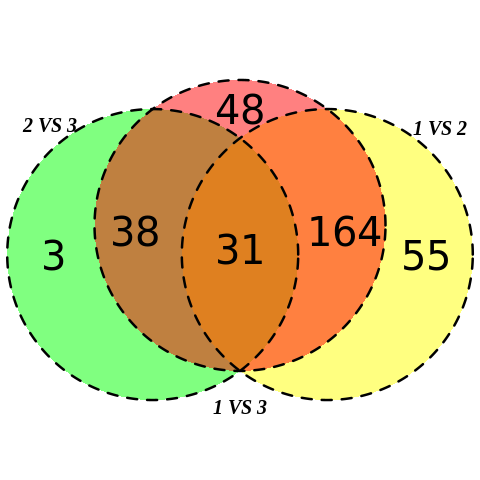

In [49]:
myvenn1 <- venn.diagram(toVenn1, filename = NULL, 
                       category.names = c("1 VS 2" , "1 VS 3" , "2 VS 3"), 
                       fill = c('yellow', 'red', 'green'),
                       alpha = c(0.5, 0.5, 0.5), 
                       cex = 2,cat.fontface = 4,
                       lty= 2, fontfamily= 3)
options(repr.plot.width=4, repr.plot.height=4)
grid.newpage()
grid.draw(myvenn1)

### 3.1.1.2 Severe Threshold Adjusted P.value < 0.0001
De los resultados de la expression diferencial podemos extraer cuales son los genes

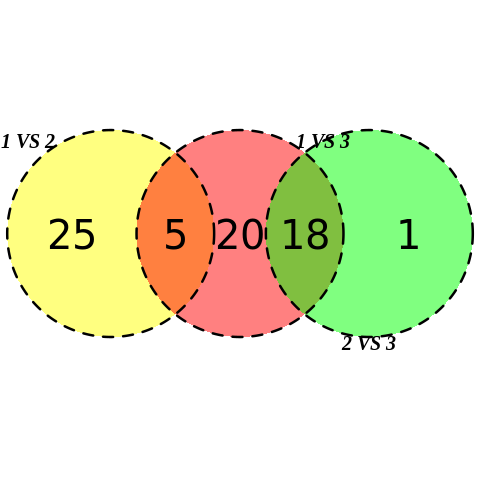

In [50]:
myvenn2 <- venn.diagram(toVenn2, filename = NULL, 
                       category.names = c("1 VS 2" , "1 VS 3" , "2 VS 3"), 
                       fill = c('yellow', 'red', 'green'),
                       alpha = c(0.5, 0.5, 0.5), 
                       cex = 2,cat.fontface = 4,
                       lty= 2, fontfamily= 3)
options(repr.plot.width=4, repr.plot.height=4)
grid.newpage()
grid.draw(myvenn2)

### 3.1.2. It's HeatMap Time
#### 3.1.2.1. Basic Threshold Adjusted P.value < 0.05 

339

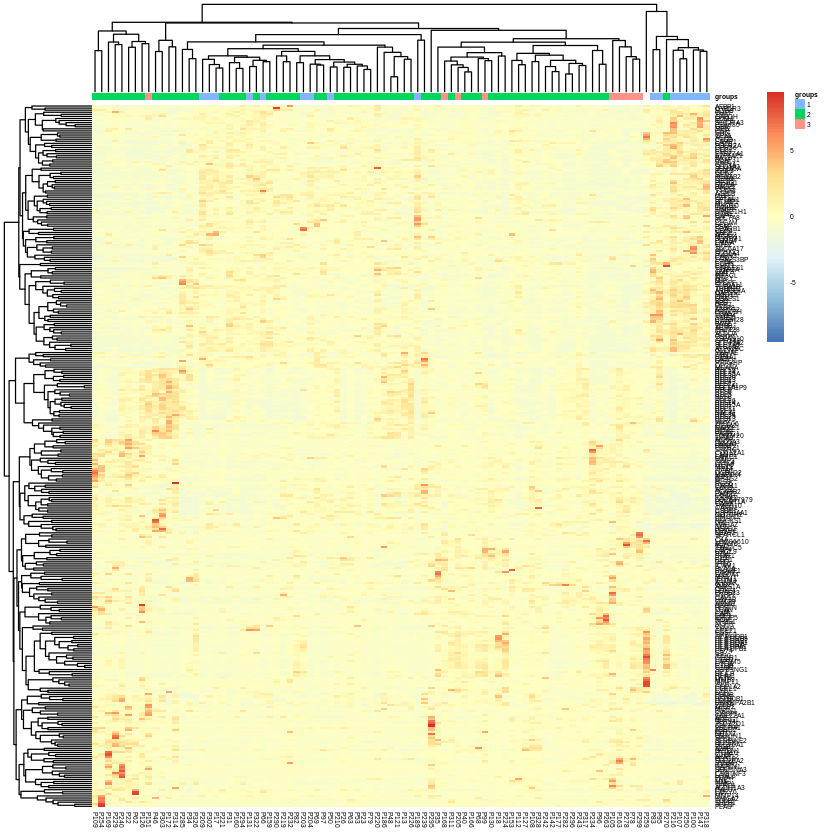

In [51]:
cat(length(commontopDiffGenes1))
options(repr.plot.width=7, repr.plot.height=7)
pheatmap(filteredMatrix[commontopDiffGenes1,],scale = "row", annotation_col = data.frame(groups), fontsize = 4)

#### 3.1.2.2. Severe Threshold Adjusted P.value < 0.0001

69

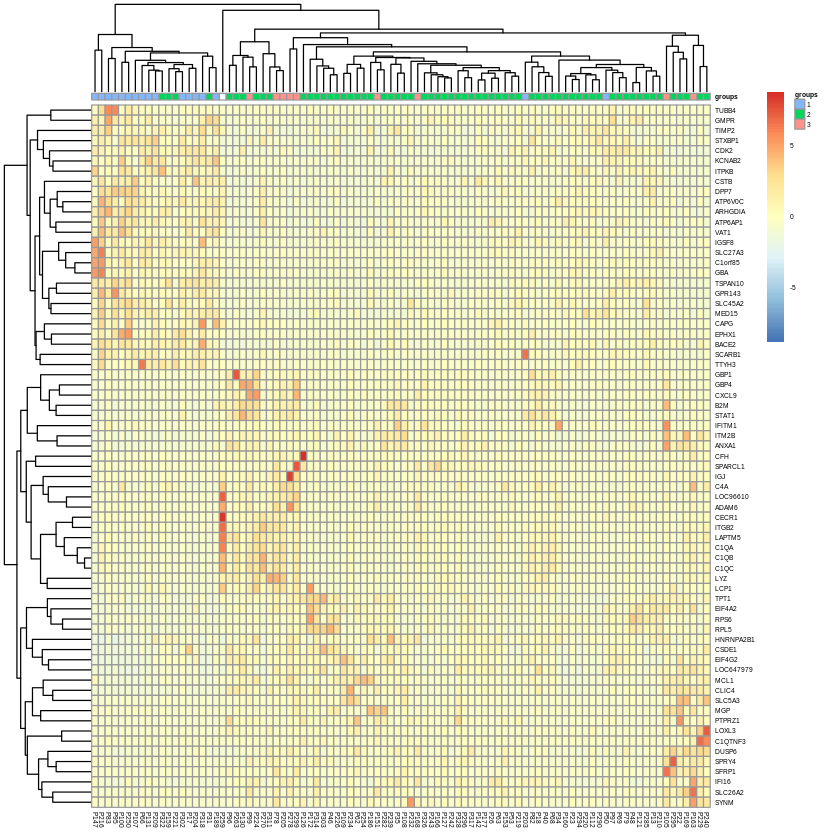

In [52]:
cat(length(commontopDiffGenes2))
options(repr.plot.width=7, repr.plot.height=7)
pheatmap(filteredMatrix[commontopDiffGenes2,],scale = "row", annotation_col = data.frame(groups), fontsize = 4)

# 4. Functional Annotation - Gene Ontology
<img src="http://geneontology.org/assets/go-logo.large.png" style="heigth: 700px;"/>

In [32]:
geneUniverse <- row.names(filteredMatrix)

In [53]:
geneUniverse12 <- top.table12$adj.P.Val
names(geneUniverse12) <- row.names(top.table12)

GOdata12 <- new("topGOdata", ontology = "BP",
           allGenes = geneUniverse12, geneSel = topDiffGenes,
           nodeSize = 1, mapping  = "org.Hs.eg.db",
           annot = annFUN.org, ID="symbol")

resultFisher12 <- runTest(GOdata12, algorithm = "classic", statistic = "fisher")
resultKS12 <- runTest(GOdata12, algorithm = "classic", statistic = "ks")
resultKS.elim12 <- runTest(GOdata12, algorithm = "elim", statistic = "ks")

allRes12 <- GenTable(GOdata12, classicFisher = resultFisher12, classicKS = resultKS12,
                    elimKS = resultKS.elim12, orderBy = "elimKS", ranksOf = "classicFisher", 
                    topNodes = 25)

geneUniverse13 <- top.table13$adj.P.Val
names(geneUniverse13) <- row.names(top.table13)

GOdata13 <- new("topGOdata", ontology = "BP",
              allGenes = geneUniverse13, geneSel = topDiffGenes,
              nodeSize = 1, mapping  = "org.Hs.eg.db",
              annot = annFUN.org, ID="symbol")

resultFisher13 <- runTest(GOdata13, algorithm = "classic", statistic = "fisher")
resultKS13 <- runTest(GOdata13, algorithm = "classic", statistic = "ks")
resultKS.elim13 <- runTest(GOdata13, algorithm = "elim", statistic = "ks")

allRes13 <- GenTable(GOdata13, classicFisher = resultFisher13, classicKS = resultKS13,
                     elimKS = resultKS.elim13, orderBy = "elimKS", ranksOf = "classicFisher", 
                     topNodes = 25)

geneUniverse23 <- top.table13$adj.P.Val
names(geneUniverse23) <- row.names(top.table23)

GOdata23 <- new("topGOdata", ontology = "BP",
              allGenes = geneUniverse23, geneSel = topDiffGenes,
              nodeSize = 1, mapping  = "org.Hs.eg.db",
              annot = annFUN.org, ID="symbol",)

resultFisher23 <- runTest(GOdata23, algorithm = "classic", statistic = "fisher")
resultKS23 <- runTest(GOdata23, algorithm = "classic", statistic = "ks")
resultKS.elim23 <- runTest(GOdata23, algorithm = "elim", statistic = "ks")

allRes23 <- GenTable(GOdata23, classicFisher = resultFisher23, classicKS = resultKS23,
                     elimKS = resultKS.elim23, orderBy = "elimKS", ranksOf = "classicFisher", 
                     topNodes = 25)


Building most specific GOs .....
	( 3380 GO terms found. )

Build GO DAG topology ..........
	( 7139 GO terms and 16487 relations. )

Annotating nodes ...............
	( 649 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 3783 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Classic Algorithm -- 

		 the algorithm is scoring 7139 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 score order: increasing

			 -- Elim Algorithm -- 

		 the algorithm is scoring 7139 nontrivial nodes
		 parameters: 
			 test statistic: ks
			 cutOff: 0.01
			 score order: increasing

	 Level 20:	1 nodes to be scored	(0 eliminated genes)

	 Level 19:	3 nodes to be scored	(0 eliminated genes)

	 Level 18:	7 nodes to be scored	(0 eliminated genes)

	 Level 17:	15 nodes to be scored	(0 eliminated genes)

	 Level 16:	29 nodes to be scored	(0 eliminated genes)

	 Level 15:	67 nodes to be scored	(0 eliminated genes)

	 Level 14:	127 nodes 

In [107]:
head(allRes12, n = 10)

GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
GO:0001818,negative regulation of cytokine producti...,18,12,3.97,4,4.7e-05,4.1e-05,4.1e-05
GO:0070373,negative regulation of ERK1 and ERK2 cas...,9,8,1.98,3,3.5e-05,0.00023,0.00023
GO:0033280,response to vitamin D,6,4,1.32,155,0.0235,0.00103,0.00103
GO:1902106,negative regulation of leukocyte differe...,8,5,1.76,131,0.0153,0.00213,0.00213
GO:0048066,developmental pigmentation,12,8,2.64,22,0.0010,0.00265,0.00265
GO:0006865,amino acid transport,8,5,1.76,132,0.0153,0.00272,0.00272
GO:0030334,regulation of cell migration,85,27,18.73,140,0.0169,0.00105,0.00294
GO:0015672,monovalent inorganic cation transport,23,12,5.07,23,0.0012,0.00314,0.00314
GO:0110110,positive regulation of animal organ morp...,6,3,1.32,705,0.1245,0.00320,0.00320
GO:0032652,regulation of interleukin-1 production,9,6,1.98,50,0.0048,0.00322,0.00322


In [34]:
head(allRes13, n = 10)

GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
GO:0030449,regulation of complement activation,14,11,3.88,5,9.4e-05,9.8e-05,9.8e-05
GO:0043547,positive regulation of GTPase activity,14,9,3.88,45,0.00427,0.00010,0.00010
GO:0006958,"complement activation, classical pathway",10,8,2.77,25,0.00082,0.00041,0.00041
GO:0043407,negative regulation of MAP kinase activi...,7,6,1.94,36,0.00230,0.00052,0.00052
GO:0070373,negative regulation of ERK1 and ERK2 cas...,9,8,2.50,9,0.00021,0.00108,0.00108
GO:0031328,positive regulation of cellular biosynth...,83,27,23.02,582,0.17979,0.00165,0.00165
GO:0032649,regulation of interferon-gamma productio...,6,4,1.66,185,0.05309,0.00274,0.00274
GO:0045123,cellular extravasation,6,4,1.66,186,0.05309,0.00296,0.00296
GO:0032675,regulation of interleukin-6 production,7,4,1.94,380,0.09742,0.00298,0.00298
GO:0050852,T cell receptor signaling pathway,13,9,3.61,31,0.00200,0.00305,0.00305


In [35]:
head(allRes23, n = 10)

GO.ID,Term,Annotated,Significant,Expected,Rank in classicFisher,classicFisher,classicKS,elimKS
GO:0006958,"complement activation, classical pathway",10,9,2.87,20,8.5e-05,3.5e-06,3.5e-06
GO:0060333,interferon-gamma-mediated signaling path...,20,15,5.73,9,1.7e-05,1.9e-05,1.9e-05
GO:0030449,regulation of complement activation,14,11,4.01,25,0.00013,3.3e-05,3.3e-05
GO:0045087,innate immune response,82,45,23.50,2,7.9e-08,5.1e-07,0.00048
GO:0051607,defense response to virus,11,9,3.15,36,0.00035,0.00067,0.00067
GO:0019886,antigen processing and presentation of e...,16,10,4.59,66,0.00449,0.00084,0.00084
GO:0070268,cornification,18,5,5.16,2919,0.62321,0.00097,0.00097
GO:0071356,cellular response to tumor necrosis fact...,12,9,3.44,52,0.00106,0.00110,0.00110
GO:0050852,T cell receptor signaling pathway,13,8,3.73,100,0.01285,0.00156,0.00156
GO:1903708,positive regulation of hemopoiesis,10,8,2.87,51,0.00104,0.00377,0.00377


Loading required package: Rgraphviz

Attaching package: ‘Rgraphviz’

The following objects are masked from ‘package:IRanges’:

    from, to

The following objects are masked from ‘package:S4Vectors’:

    from, to



$dag
A graphNEL graph with directed edges
Number of Nodes = 153 
Number of Edges = 331 

$complete.dag
[1] "A graph with 153 nodes."


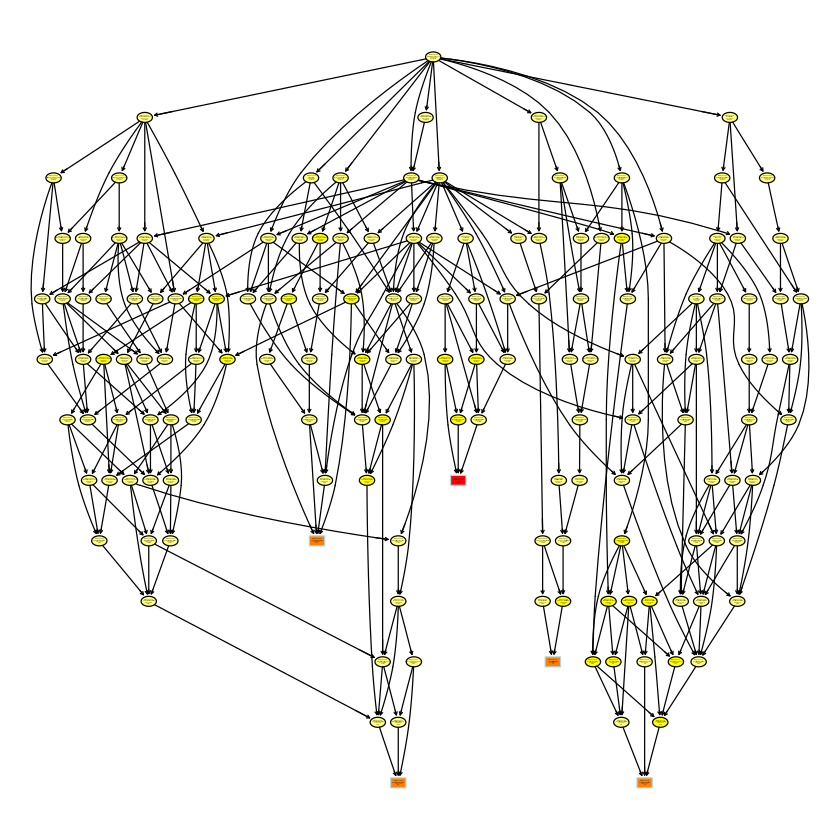

In [54]:
showSigOfNodes(GOdata12, score(resultKS.elim12), firstSigNodes = 5, useInfo = 'all')
#showSigOfNodes(GOdata23, score(resultKS.elim23), firstSigNodes = 5, useInfo = 'all')
#showSigOfNodes(GOdata13, score(resultKS.elim13), firstSigNodes = 5, useInfo = 'all')

In [36]:
writeLines(paste(paste0(allRes12$GO.ID,"    ",allRes12$elimKS), collapse = "\n"))

GO:0043065    0.00046
GO:0070373    0.00179
GO:0090288    0.00276
GO:0030183    0.00383
GO:2000778    0.00448
GO:0010647    0.00590
GO:0098656    0.00612
GO:0071103    0.00660
GO:0098660    0.00664
GO:0006821    0.00708
GO:0043407    0.00718
GO:0019751    0.00722
GO:0001960    0.00746
GO:0010524    0.00874
GO:2000811    0.00881
GO:0002253    0.00916
GO:0015849    0.01050
GO:0046942    0.01050
GO:0043547    0.01103
GO:0016311    0.01130
GO:1903427    0.01137
GO:0010955    0.01150
GO:1903318    0.01150
GO:0023056    0.01196
GO:0006954    0.01199


In [37]:
writeLines(paste(paste0(allRes13$GO.ID,"    ",allRes13$elimKS), collapse = "\n"))

GO:0030449    9.8e-05
GO:0043547    0.00010
GO:0006958    0.00041
GO:0043407    0.00052
GO:0070373    0.00108
GO:0031328    0.00165
GO:0032649    0.00274
GO:0045123    0.00296
GO:0032675    0.00298
GO:0050852    0.00305
GO:0045620    0.00329
GO:0045621    0.00329
GO:0045321    0.00430
GO:0098656    0.00451
GO:0010557    0.00527
GO:0019886    0.00553
GO:0070555    0.00558
GO:0002252    0.00563
GO:0034248    0.00662
GO:0050715    0.00717
GO:0065004    0.00723
GO:1902253    0.00723
GO:0046637    0.00839
GO:0032147    0.00856
GO:2001020    0.00931


In [38]:
writeLines(paste(paste0(allRes23$GO.ID,"    ",allRes23$elimKS), collapse = "\n"))

GO:0006958    3.5e-06
GO:0060333    1.9e-05
GO:0030449    3.3e-05
GO:0045087    0.00048
GO:0051607    0.00067
GO:0019886    0.00084
GO:0070268    0.00097
GO:0071356    0.00110
GO:0050852    0.00156
GO:1903708    0.00377
GO:0070741    0.00401
GO:0001516    0.00439
GO:1902532    0.00473
GO:0048872    0.00479
GO:0002250    0.00549
GO:0070555    0.00707
GO:0001775    0.00742
GO:0045581    0.00759
GO:2000427    0.00881
GO:0010742    0.00972
GO:0006974    0.01003
GO:0070373    0.01006
GO:0071347    0.01013
GO:0045621    0.01055
GO:2000107    0.01055
